In [1]:
import numpy as np
import scipy.io
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Цель вычислительного эксперимента:
Необходимо решить задачу регрессии с использованием моделей: линейная регрессия, PCA + линейная регрессия, простая нейросеть и критериями качества: квадратичная ошибка, число обусловленности.
## Описание выборок:
Используется датасет ECoG, уже разбитый на выборки обучение/контроль.
## Блок загрузки и предобработки выборок:

In [60]:
X_train = scipy.io.loadmat('ECoG_X_train.mat')['X_train']
y_train = scipy.io.loadmat('ECoG_Y_train.mat')['Y_train']
X_test = scipy.io.loadmat('ECoG_X_test.mat')['X_hold_out']
y_test = scipy.io.loadmat('ECoG_Y_test.mat')['Y_hold_out']

In [61]:
X_train.shape

(12801, 32, 27)

In [62]:
y_train.shape

(12801, 3)

In [63]:
X_test.shape

(6087, 32, 27)

In [64]:
y_test.shape

(6087, 3)

In [65]:
X_train = np.array([i.flatten() for i in X_train])
X_test = np.array([i.flatten() for i in X_test])

## Анализ пропусков

In [66]:
np.isnan(X_train).any()

False

In [67]:
np.isnan(y_train).any()

False

Пропусков нет, стандартизуем признаки

In [68]:
X_train[:5]

array([[-10.53325227,  18.93917097,  18.55297218, ...,  17.41499459,
         16.60704448,  16.44891843],
       [ -4.77331163,  19.21923275,  18.77207285, ...,  16.69949724,
         15.89956714,  14.98486893],
       [ -5.9887654 ,  19.46942629,  19.07727324, ...,  15.68502365,
         15.84936956,  15.5314882 ],
       [-26.15385144,  19.68994391,  19.39824895, ...,  14.31815054,
         15.05489211,  13.0243632 ],
       [-35.92105998,  19.87891709,  19.6599213 , ...,  15.28387576,
         12.1479463 ,  15.12609582]])

## Список моделей
Для решения поставленной задачи используются следующие модели:
* линейная регрессия
* PCA + линейная регрессия
* простая нейросеть 

## Список критериев качетсва:
* mean squared error
* variance score

## Линейная регрессия:

In [74]:
linreg = LinearRegression(normalize=True)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [75]:
res = linreg.predict(X_test)

In [76]:
mean_squared_error(y_test, res)

1786.7787691924377

In [77]:
explained_variance_score(y_test,res)

0.0703714702511365

In [78]:
err = np.zeros((y_train.shape[0] // 100, 7))
k = y_test.shape[0] // 7 + (y_test.shape[0] % 7 > 0)
for i in range(y_train.shape[0] // 100):
    print("\r       \r" + str(i), end="")
    linreg.fit(X_train[:100 * (i + 1)], y_train[:100 * (i + 1)])
    y_predicted = linreg.predict(X_test)
    for j in range(7):
        err[i][j] = mean_squared_error(y_test[k * j: k * (j + 1)], y_predicted[k * j: k * (j + 1)])

127    

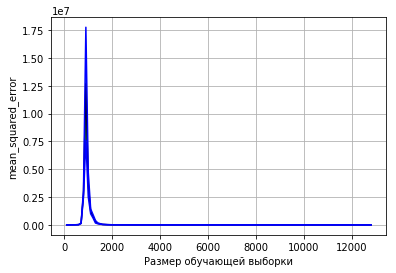

In [79]:
err_mean = np.mean(err, axis=1)
err_std = np.std(err, axis=1)
#plt.title("Зависимость ошибки от размера обучающей выборки")
plt.plot(range(100, y_train.shape[0], 100), err_mean, 'k-')
plt.plot(range(100, y_train.shape[0], 100), err_mean - err_std, 'b-')
plt.plot(range(100, y_train.shape[0], 100), err_mean + err_std, 'b-')
plt.fill_between(range(100, y_train.shape[0], 100), err_mean - err_std, err_mean + err_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("mean_squared_error")
plt.show()

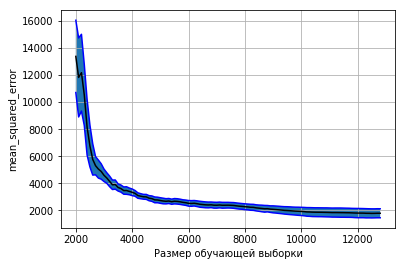

In [80]:
err_mean = np.mean(err, axis=1)
err_std = np.std(err, axis=1)
#plt.title("Зависимость ошибки от размера обучающей выборки")
plt.plot(range(2000, y_train.shape[0], 100), err_mean[19:], 'k-')
plt.plot(range(2000, y_train.shape[0], 100), err_mean[19:] - err_std[19:], 'b-')
plt.plot(range(2000, y_train.shape[0], 100), err_mean[19:] + err_std[19:], 'b-')
plt.fill_between(range(2000, y_train.shape[0], 100), err_mean[19:] - err_std[19:], err_mean[19:] + err_std[19:])
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("mean_squared_error")
plt.show()

## Линейная регрессия c PCA до 80 компонент

In [81]:
pca = PCA(n_components=80)
pipe = Pipeline(steps=[('pca', pca), ('model', linreg)])

In [82]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [83]:
res = pipe.predict(X_test)

In [84]:
mean_squared_error(y_test, res) 

1635.0175970447362

In [85]:
explained_variance_score(y_test,res)

0.147059894007987

In [86]:
err = np.zeros((y_train.shape[0] // 100, 7))
k = y_test.shape[0] // 7 + (y_test.shape[0] % 7 > 0)
for i in range(y_train.shape[0] // 100):
    print("\r       \r" + str(i), end="")
    pipe.fit(X_train[:100 * (i + 1)], y_train[:100 * (i + 1)])
    y_predicted = pipe.predict(X_test)
    for j in range(7):
        err[i][j] = mean_squared_error(y_test[k * j: k * (j + 1)], y_predicted[k * j: k * (j + 1)])

127    

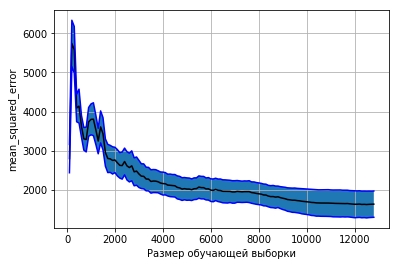

In [87]:
err_mean = np.mean(err, axis=1)
err_std = np.std(err, axis=1)
#plt.title("Зависимость ошибки от размера обучающей выборки")
plt.plot(range(100, y_train.shape[0], 100), err_mean, 'k-')
plt.plot(range(100, y_train.shape[0], 100), err_mean - err_std, 'b-')
plt.plot(range(100, y_train.shape[0], 100), err_mean + err_std, 'b-')
plt.fill_between(range(100, y_train.shape[0], 100), err_mean - err_std, err_mean + err_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("mean_squared_error")
plt.show()

## Нейронная сеть

In [101]:
def big_model():
    model = Sequential()
    model.add(Dense(512, input_dim=864, kernel_initializer='normal', 
                    activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(256, kernel_initializer='normal', activation='relu',
                   kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [102]:
neural_net = KerasRegressor(big_model,epochs=100, batch_size=200,verbose=1)
model = neural_net
pipe = Pipeline(steps=[('scaler',scaler),('model', model)])

In [103]:
pipe.fit(X_train,y_train)

Epoch 1/100
12801/12801 [==============================] - 1s 91us/step - loss: 13342.5266
Epoch 2/100
12801/12801 [==============================] - 1s 63us/step - loss: 4060.4288
Epoch 3/100
12801/12801 [==============================] - 1s 60us/step - loss: 3352.4759
Epoch 4/100
12801/12801 [==============================] - 1s 67us/step - loss: 2947.7736
Epoch 5/100
12801/12801 [==============================] - 1s 63us/step - loss: 2702.1991
Epoch 6/100
12801/12801 [==============================] - 1s 63us/step - loss: 2526.6500
Epoch 7/100
12801/12801 [==============================] - 1s 64us/step - loss: 2373.4829
Epoch 8/100
12801/12801 [==============================] - 1s 67us/step - loss: 2264.5534
Epoch 9/100
12801/12801 [==============================] - 1s 68us/step - loss: 2133.3137
Epoch 10/100
12801/12801 [==============================] - 1s 64us/step - loss: 1993.6595
Epoch 11/100
12801/12801 [==============================] - 1s 64us/step - loss: 1978.2901
Epoch 1

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000025918BFB978>)])

In [104]:
res = pipe.predict(X_test)

6087/6087 [==============================] - 0s 27us/step


In [105]:
mean_squared_error(y_test, res) 

2281.023837411724

In [106]:
explained_variance_score(y_test, res)

-0.16258658114131663

In [110]:
err = np.zeros((5, 7))
k = y_test.shape[0] // 7 + (y_test.shape[0] % 7 > 0)
for i, n_epoch in enumerate([1, 5, 10, 20, 50]):
    model = KerasRegressor(big_model, epochs=n_epoch, batch_size=100, verbose=0)
    pipe = Pipeline(steps=[('scaler', scaler), ('model', model)])
    pipe.fit(X_train, y_train)
    res = pipe.predict(X_test)
    for j in range(7):
        err[i][j] = mean_squared_error(y_test[k * j: k * (j + 1)], res[k * j: k * (j + 1)])

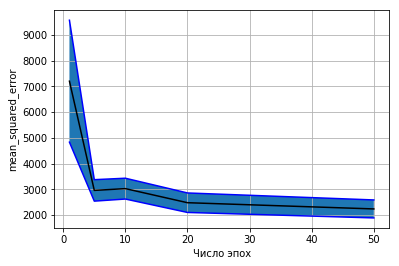

In [112]:
err_mean = np.mean(err, axis=1)
err_std = np.std(err, axis=1)
#plt.title("Зависимость ошибки от размера обучающей выборки")
plt.plot([1, 5, 10, 20, 50], err_mean, 'k-')
plt.plot([1, 5, 10, 20, 50], err_mean - err_std, 'b-')
plt.plot([1, 5, 10, 20, 50], err_mean + err_std, 'b-')
plt.fill_between([1, 5, 10, 20, 50], err_mean - err_std, err_mean + err_std)
plt.grid()
plt.xlabel("Число эпох")
plt.ylabel("mean_squared_error")
plt.show()

In [115]:
def variable_model():
    model = Sequential()
    model.add(Dense(64, input_dim=864, kernel_initializer='normal', activation='relu'))
    for i in range(n_l-1):
        model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model
results1 = []
n_layers = [1, 2, 3]
err = np.zeros((3, 7))
for i, n_l in enumerate(n_layers):
    model = KerasRegressor(variable_model,epochs=10, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train, y_train)
    res = pipe.predict(X_test)
    for j in range(7):
        err[i][j] = mean_squared_error(y_test[k * j: k * (j + 1)], res[k * j: k * (j + 1)]) 

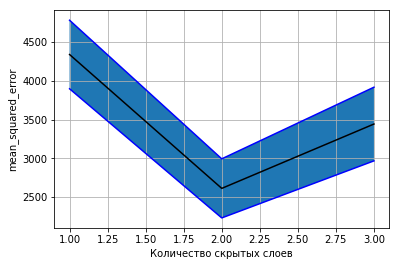

In [116]:
err_mean = np.mean(err, axis=1)
err_std = np.std(err, axis=1)
#plt.title("Зависимость ошибки от размера обучающей выборки")
plt.plot([1, 2, 3], err_mean, 'k-')
plt.plot([1, 2, 3], err_mean - err_std, 'b-')
plt.plot([1, 2, 3], err_mean + err_std, 'b-')
plt.fill_between([1, 2, 3], err_mean - err_std, err_mean + err_std)
plt.grid()
plt.xlabel("Количество скрытых слоев")
plt.ylabel("mean_squared_error")
plt.show()

In [121]:
percents_of_data = np.arange(0.1, 1.001, 0.05)
err = np.zeros((19, 7))
for i, pod in enumerate(percents_of_data):
    print("\r     \r" + str(pod), end="")
    model = KerasRegressor(big_model,epochs=10, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train[:int(len(X_train)*pod)],y_train[:int(len(X_train)*pod)])
    res = pipe.predict(X_test)
    for j in range(7):
        err[i][j] = mean_squared_error(y_test[k * j: k * (j + 1)], res[k * j: k * (j + 1)])    

1.00000000000000047

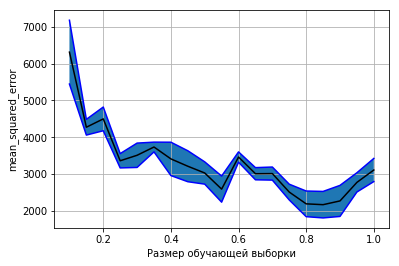

In [122]:
err_mean = np.mean(err, axis=1)
err_std = np.std(err, axis=1)
#plt.title("Зависимость ошибки от размера обучающей выборки")
plt.plot(percents_of_data, err_mean, 'k-')
plt.plot(percents_of_data, err_mean - err_std, 'b-')
plt.plot(percents_of_data, err_mean + err_std, 'b-')
plt.fill_between(percents_of_data, err_mean - err_std, err_mean + err_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("mean_squared_error")
plt.show()